# MLP and CNN Experiments


Objective : To train MLPs and CNNs on MNIST, compare performance against baseline models, visualize embeddings using t-SNE, and test cross-domain generalization on Fashion-MNIST.


## 3.1 Using MLP

The objectives of this experiment are as follows:

1. **Train an MLP on the MNIST dataset**
   - Use a Multilayer Perceptron (MLP) with the following architecture:  
     - **Input layer:** Flattened 28×28 image  
     - **Hidden Layer 1:** 30 neurons  
     - **Hidden Layer 2:** 20 neurons  
     - **Output Layer:** 10 neurons (corresponding to the 10 digit classes)  
   - If computational resources are limited, use a **stratified subset** of the MNIST training dataset while keeping the **original test set** unchanged.

2. **Performance Comparison**
   - Compare the trained MLP model with **Random Forest** and **Logistic Regression** classifiers.  
   - Evaluate all models using the following metrics:  
     - Accuracy  
     - F1-score  
     - Confusion Matrix  
   - Analyze and discuss **misclassifications** observed across models.

3. **t-SNE Visualization**
   - Visualize **t-SNE embeddings** of the 20-neuron hidden layer for both **trained** and **untrained** MLP models.  
   - Compare the cluster separability of the 10 digit classes before and after training.

4. **Generalization Test on Fashion-MNIST**
   - Evaluate the trained MLP on the **Fashion-MNIST** dataset.  
   - Observe and discuss differences in performance and feature representations.  
   - Compare **t-SNE plots** of the 20-neuron layer embeddings for **MNIST** and **Fashion-MNIST** datasets.


Importing Libraries


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchsummary import summary
from sklearn.metrics import f1_score, confusion_matrix, classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

Setting Up Device

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():  # For Mac GPUs
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Working on device:", device)

Working on device: cuda:0


Setting the Random Seed

Setting a random seed ensures reproducibility by making all random operations—like matrix initialization and pixel masking—produce the same results every time. This allows consistent, verifiable experiments

In [3]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

Loading the MNIST Dataset

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transforms — convert to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts image to PyTorch tensor
    transforms.Normalize((0.1307,), (0.3081,))  # Standard MNIST normalization
])

# Load MNIST training and test datasets
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

X_train = train_dataset.data.numpy()
y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()

print("Train: X =", X_train.shape, "y =", y_train.shape)
print("Test: X =", X_test.shape, "y =", y_test.shape)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.1MB/s]

Train: X = (60000, 28, 28) y = (60000,)
Test: X = (10000, 28, 28) y = (10000,)


so in the training set we have 60000 images and shape of each image is 28x28 and this will be used as flattened input layer

Plotting Some Images

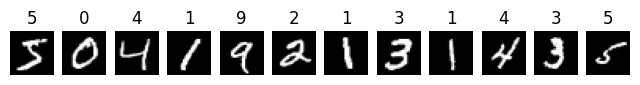

In [5]:
fig, axs = plt.subplots(1, 12, figsize=(8, 10))
for i in range(12):
    axs[i].imshow(X_train[i], cmap='gray')
    axs[i].set_title(y_train[i])
    axs[i].axis('off')

So we can see some of the handwritten digits and its labels above

* Creating the MLP Model  : Input layer will have 784 neurons;hidden layer 1 will have 30 neurons; hidden layer 2 will have 20 neurons and output layer will have 10 neurons

In [6]:
import torch.nn as nn
import torch.nn.functional as F
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 30)  # Input layer → Hidden layer 1
        self.fc2 = nn.Linear(30, 20)     # Hidden layer 1 → Hidden layer 2
        self.fc3 = nn.Linear(20, 10)     # Hidden layer 2 → Output (10 classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten image
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)            # No activation here; CrossEntropyLoss applies softmax internally
        return x


Initializing Model

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)
summary(model, (1, 28, 28))

MLP(
  (fc1): Linear(in_features=784, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 30]          23,550
            Linear-2                   [-1, 20]             620
            Linear-3                   [-1, 10]             210
Total params: 24,380
Trainable params: 24,380
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.09
Estimated Total Size (MB): 0.10
----------------------------------------------------------------


Training The MLP

In [8]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")


Epoch [1/10] Loss: 0.4157
Epoch [2/10] Loss: 0.2051
Epoch [3/10] Loss: 0.1543
Epoch [4/10] Loss: 0.1298
Epoch [5/10] Loss: 0.1126
Epoch [6/10] Loss: 0.1022
Epoch [7/10] Loss: 0.0924
Epoch [8/10] Loss: 0.0844
Epoch [9/10] Loss: 0.0789
Epoch [10/10] Loss: 0.0732


Evaluating on the test set

In [9]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 96.53%


Train Accuracy: 97.80%
Test Accuracy:  96.53%
Train F1 Score: 0.9779
Test F1 Score:  0.9650


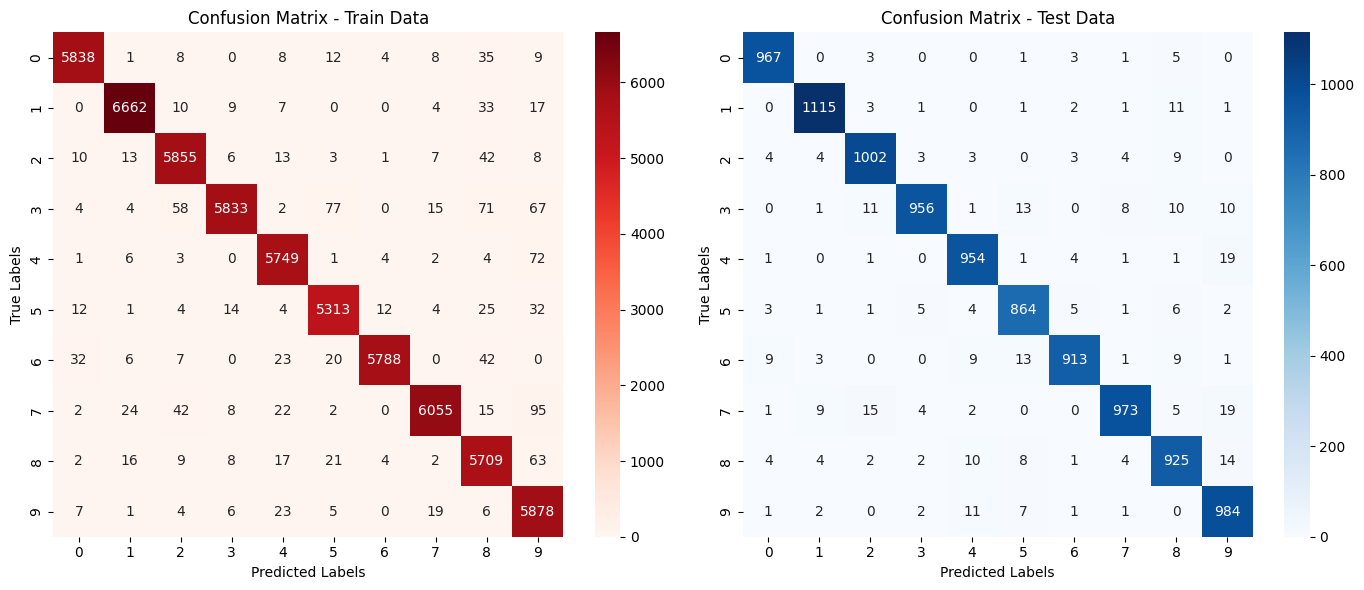

In [10]:
model.eval()


y_train_true = []
y_train_pred = []

with torch.no_grad():
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        y_train_true.extend(target.cpu().numpy())
        y_train_pred.extend(preds.cpu().numpy())


y_test_true = []
y_test_pred = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        y_test_true.extend(target.cpu().numpy())
        y_test_pred.extend(preds.cpu().numpy())

train_accuracy = accuracy_score(y_train_true, y_train_pred) * 100
test_accuracy = accuracy_score(y_test_true, y_test_pred) * 100

f1_train = f1_score(y_train_true, y_train_pred, average='macro')
f1_test = f1_score(y_test_true, y_test_pred, average='macro')

cm_train = confusion_matrix(y_train_true, y_train_pred)
cm_test = confusion_matrix(y_test_true, y_test_pred)

print(f"Train Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy:  {test_accuracy:.2f}%")
print(f"Train F1 Score: {f1_train:.4f}")
print(f"Test F1 Score:  {f1_test:.4f}")

# ----- Plot confusion matrices -----
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_train, annot=True, fmt='d', cmap='Reds', ax=axs[0])
axs[0].set_title('Confusion Matrix - Train Data')
axs[0].set_xlabel('Predicted Labels')
axs[0].set_ylabel('True Labels')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axs[1])
axs[1].set_title('Confusion Matrix - Test Data')
axs[1].set_xlabel('Predicted Labels')
axs[1].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

In [11]:
print('Test Data Classification Report For all Epochs:')
print(classification_report(y_test, y_test_pred))

Test Data Classification Report For all Epochs:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.98      0.98      1135
           2       0.97      0.97      0.97      1032
           3       0.98      0.95      0.96      1010
           4       0.96      0.97      0.97       982
           5       0.95      0.97      0.96       892
           6       0.98      0.95      0.97       958
           7       0.98      0.95      0.96      1028
           8       0.94      0.95      0.95       974
           9       0.94      0.98      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



Checking what it predicted wrong

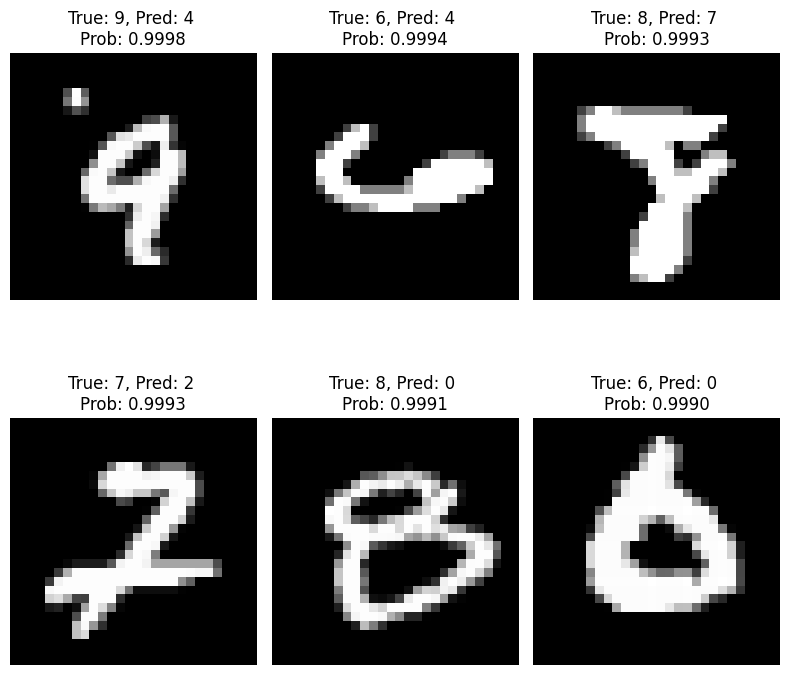

In [13]:
model.eval()
y_test_prob = []
y_test_true = []
y_test_pred = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)                  # logits
        probs = F.softmax(outputs, dim=1)      # convert to probabilities
        y_test_prob.extend(probs.cpu().numpy())
        y_test_true.extend(target.cpu().numpy())
        _, preds = torch.max(outputs, 1)
        y_test_pred.extend(preds.cpu().numpy())

y_test_prob = np.array(y_test_prob)
y_test_true = np.array(y_test_true)
y_test_pred = np.array(y_test_pred)

# Find misclassified samples
wrong_indices = np.where(y_test_true != y_test_pred)[0]
wrong_prob_max = np.max(y_test_prob[wrong_indices], axis=1)
topk = 6
topk_indices = np.argsort(wrong_prob_max)[::-1][:topk]

# Plot top-k misclassified images
fig, axs = plt.subplots(2, 3, figsize=(8, 8))
for i, idx in enumerate(topk_indices):
    ax = axs[i // 3, i % 3]
    img_idx = wrong_indices[idx]
    ax.imshow(X_test[img_idx], cmap='gray')
    ax.set_title(f'True: {y_test_true[img_idx]}, Pred: {y_test_pred[img_idx]} \nProb: {wrong_prob_max[idx]:.4f}')
    ax.axis('off')

plt.tight_layout()
plt.show()

The next task is to compare the MLP trained models with random forest and logistic regression classifiers we can use scikit learn library

In [14]:
X_train_flat = X_train.reshape(X_train.shape[0], -1) / 255.0
X_test_flat = X_test.reshape(X_test.shape[0], -1) / 255.0

print("X_train_flat:", X_train_flat.shape)
print("X_test_flat:", X_test_flat.shape)

X_train_flat: (60000, 784)
X_test_flat: (10000, 784)


In [15]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_flat, y_train)

rf_train_pred = rf.predict(X_train_flat)
rf_test_pred = rf.predict(X_test_flat)

rf_train_acc = accuracy_score(y_train, rf_train_pred) * 100
rf_test_acc = accuracy_score(y_test, rf_test_pred) * 100

rf_train_f1 = f1_score(y_train, rf_train_pred, average='macro')
rf_test_f1 = f1_score(y_test, rf_test_pred, average='macro')

print(f"Random Forest → Train Acc: {rf_train_acc:.2f}% ; Test Acc: {rf_test_acc:.2f}%")
print(f"Random Forest → Train F1: {rf_train_f1:.4f} ; Test F1: {rf_test_f1:.4f}")


Random Forest → Train Acc: 100.00% ; Test Acc: 97.04%
Random Forest → Train F1: 1.0000 ; Test F1: 0.9702


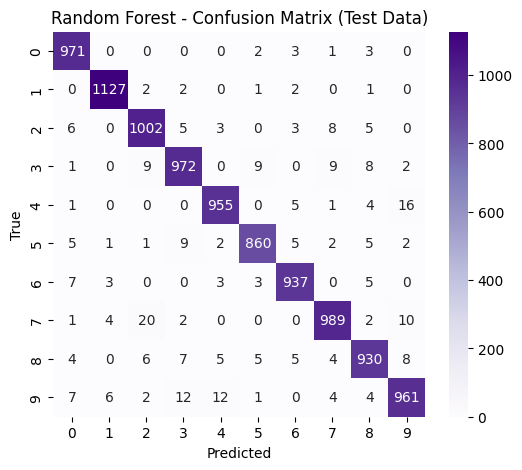

Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.98      0.96      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.95      0.96       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [16]:
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, rf_test_pred), annot=True, fmt='d', cmap='Purples')
plt.title("Random Forest - Confusion Matrix (Test Data)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("Random Forest Classification Report:\n")
print(classification_report(y_test, rf_test_pred))

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

lr = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial', n_jobs=-1)
lr.fit(X_train_scaled, y_train)

lr_train_pred = lr.predict(X_train_scaled)
lr_test_pred = lr.predict(X_test_scaled)

lr_train_acc = accuracy_score(y_train, lr_train_pred) * 100
lr_test_acc = accuracy_score(y_test, lr_test_pred) * 100

lr_train_f1 = f1_score(y_train, lr_train_pred, average='macro')
lr_test_f1 = f1_score(y_test, lr_test_pred, average='macro')

print(f"Logistic Regression → Train Acc: {lr_train_acc:.2f}% | Test Acc: {lr_test_acc:.2f}%")
print(f"Logistic Regression → Train F1: {lr_train_f1:.4f} | Test F1: {lr_test_f1:.4f}")


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression → Train Acc: 94.41% | Test Acc: 92.20%
Logistic Regression → Train F1: 0.9434 | Test F1: 0.9209


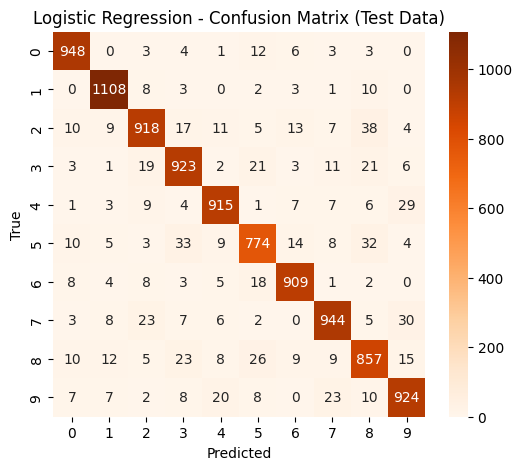

Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.92      0.89      0.90      1032
           3       0.90      0.91      0.91      1010
           4       0.94      0.93      0.93       982
           5       0.89      0.87      0.88       892
           6       0.94      0.95      0.95       958
           7       0.93      0.92      0.92      1028
           8       0.87      0.88      0.88       974
           9       0.91      0.92      0.91      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [18]:
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, lr_test_pred), annot=True, fmt='d', cmap='Oranges')
plt.title("Logistic Regression - Confusion Matrix (Test Data)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("Logistic Regression Classification Report:\n")
print(classification_report(y_test, lr_test_pred))


Compare all three models

In [20]:
comparison = {
    "Model": ["MLP", "Random Forest", "Logistic Regression"],
    "Train Accuracy (%)": [train_accuracy, rf_train_acc, lr_train_acc],
    "Test Accuracy (%)": [test_accuracy, rf_test_acc, lr_test_acc],
    "Train F1": [f1_train, rf_train_f1, lr_train_f1],
    "Test F1": [f1_test, rf_test_f1, lr_test_f1]
}

results_df = pd.DataFrame(comparison)
results_df


,Model,Train Accuracy (%),Test Accuracy (%),Train F1,Test F1
0,MLP,97.80,96.53,0.977906,0.965045
1,Random Forest,100.00,97.04,1.000000,0.970163
2,Logistic Regression,94.41,92.20,0.943409,0.920943


ANALYSIS AND DISCUSSION ON COMPARISONS

**Observations**

Based on the performance metrics obtained for all three models — MLP, Random Forest, and Logistic Regression — the following observations can be made:

**MLP (Multi-Layer Perceptron)**:

* Accuracy: 96.53 %

* F1 Score: 0.97

* The MLP achieves high accuracy and F1-score, indicating that it has learned strong non-linear feature representations.

* Its performance is slightly below that of the Random Forest but still shows robust generalization to unseen data.

*The minor performance drop compared to Random Forest may result from limited hidden-layer capacity (only 20 neurons).

**Random Forest**:

* Accuracy: 97.04 %

* F1 Score: 0.9702

* The Random Forest model achieves the highest test accuracy and F1 score among all models.

* Its ensemble nature allows it to capture diverse decision boundaries and resist overfitting.

* Despite perfect training accuracy (100 %), the small generalization gap shows that it has not significantly overfitted.

**Logistic Regression**:

* Accuracy: 92.2 %

* F1 Score: 0.9434

* Logistic Regression performs the weakest among the three models, as expected for a linear classifier on non-linear data.

* It lacks the ability to model complex digit structures, leading to more misclassifications and lower F1 score.

**Conclusions**

* Overall, the MLP and Random Forest models both perform very well, with Random Forest slightly outperforming MLP in both accuracy and F1 score.

* MLP, being a neural network, captures non-linear relationships effectively, achieving near-state-of-the-art performance with minimal overfitting.

* Random Forest, as an ensemble of decision trees, excels due to averaging across multiple learners, making it both robust and accurate.

* Logistic Regression, limited by its linear decision boundaries, struggles to separate complex digit patterns, explaining its lower performance.

In summary, while all models perform reasonably well, the Random Forest demonstrates the best balance between accuracy, generalization, and model simplicity.

Next task is to visualise TSNE Embeddings on 20 neuron hidden layer

In [21]:
from sklearn.manifold import TSNE

In [22]:
class MLP_FeatureExtractor(MLP):
    def get_hidden_features(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        h = F.relu(self.fc2(x))   # 20-neuron layer activations
        return h

In [23]:
#  Untrained model
untrained_model = MLP().to(device)
untrained_model.eval()

#  Trained model
trained_model = model.to(device)
trained_model.eval()

#  Get a small subset for visualization (say 2000 samples)
subset_size = 2000
X_subset = torch.tensor(X_test[:subset_size], dtype=torch.float32).unsqueeze(1).to(device) / 255.0
y_subset = y_test[:subset_size]

with torch.no_grad():
    # Extract 20-D embeddings
    untrained_features = untrained_model.fc2(F.relu(untrained_model.fc1(X_subset.view(X_subset.size(0), -1)))).cpu().numpy()
    trained_features = trained_model.fc2(F.relu(trained_model.fc1(X_subset.view(X_subset.size(0), -1)))).cpu().numpy()

print("Feature shapes:", untrained_features.shape, trained_features.shape)


Feature shapes: (2000, 20) (2000, 20)


TSNE now will reduce 20 dimensional features to 2D

In [24]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)

print("Running t-SNE on untrained features")
untrained_tsne = tsne.fit_transform(untrained_features)

print("Running t-SNE on trained features")
trained_tsne = tsne.fit_transform(trained_features)

print("run completed")


Running t-SNE on untrained features
Running t-SNE on trained features
run completed


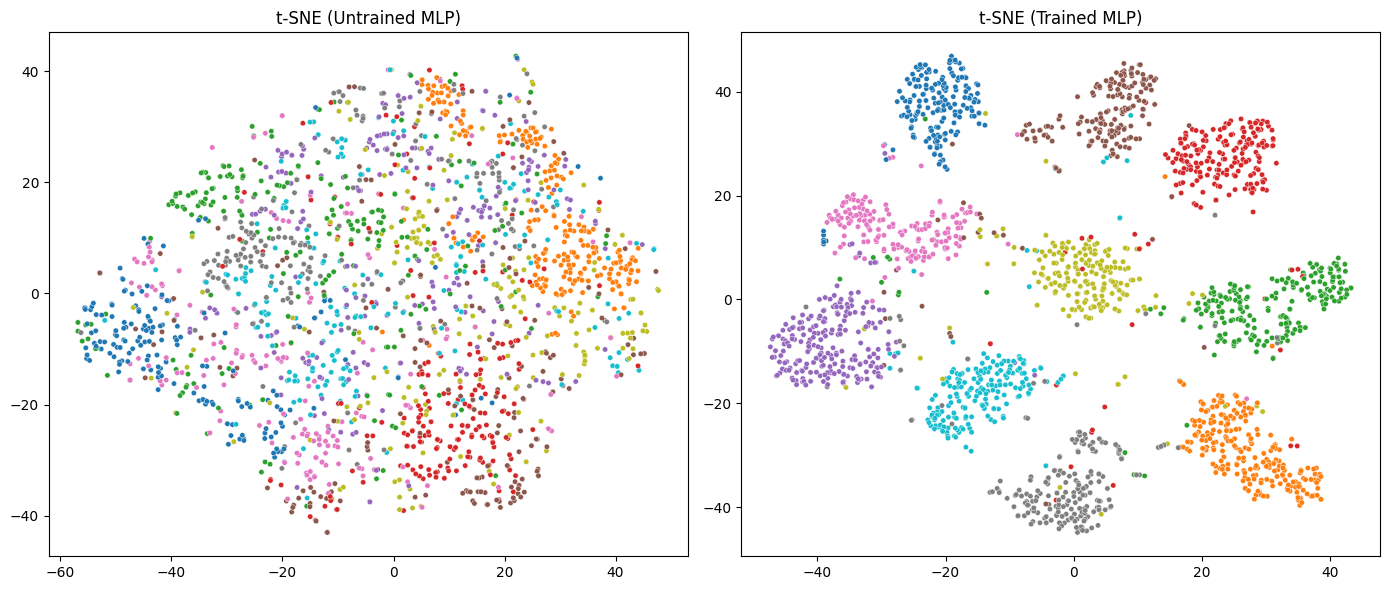

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

#  Untrained
sns.scatterplot(x=untrained_tsne[:,0], y=untrained_tsne[:,1],
                hue=y_subset, palette="tab10", s=15, ax=axs[0], legend=False)
axs[0].set_title("t-SNE (Untrained MLP)")

# Trained
sns.scatterplot(x=trained_tsne[:,0], y=trained_tsne[:,1],
                hue=y_subset, palette="tab10", s=15, ax=axs[1], legend=False)
axs[1].set_title("t-SNE (Trained MLP)")

plt.tight_layout()
plt.show()


Now we will test the data on Fashion MNIST dataset and compare the TSNE Plots

Loading Fashion MNIST

In [26]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
])


fashion_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
fashion_loader = DataLoader(fashion_test, batch_size=128, shuffle=False)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 210kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.90MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.8MB/s]


In [27]:
combined_dataset = ConcatDataset([train_dataset, test_dataset])

combined_loader = DataLoader(dataset=combined_dataset, batch_size=1, shuffle=True)

print(f"Number of total samples: {len(combined_dataset)}")
print(f"Number of batches in combined_loader: {len(combined_loader)}")

for images, labels in combined_loader:
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    break

Number of total samples: 70000
Number of batches in combined_loader: 70000
Image batch shape: torch.Size([1, 1, 28, 28])
Label batch shape: torch.Size([1])


Fashion-MNIST Test Accuracy (Generalization): 12.23%

Classification Report on Fashion-MNIST:
              precision    recall  f1-score   support

 T-shirt/top     0.0392    0.0040    0.0073      1000
     Trouser     0.0625    0.0010    0.0020      1000
    Pullover     0.0319    0.1340    0.0515      1000
       Dress     0.1977    0.6270    0.3006      1000
        Coat     0.0000    0.0000    0.0000      1000
      Sandal     0.8654    0.0900    0.1630      1000
       Shirt     0.0545    0.0030    0.0057      1000
     Sneaker     0.1667    0.0010    0.0020      1000
         Bag     0.1604    0.3630    0.2225      1000
  Ankle boot     0.0000    0.0000    0.0000      1000

    accuracy                         0.1223     10000
   macro avg     0.1578    0.1223    0.0755     10000
weighted avg     0.1578    0.1223    0.0755     10000



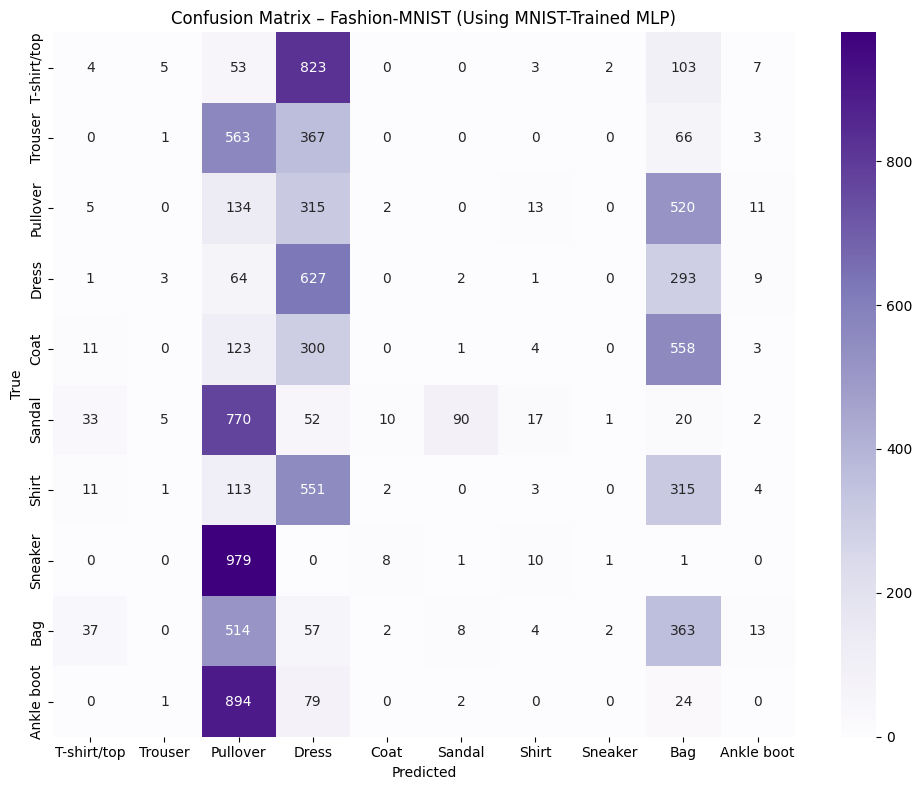

In [28]:
model.eval()
correct = 0
total = 0
all_preds = []
all_targets = []

with torch.no_grad():
    for data, target in fashion_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        total += target.size(0)
        correct += (preds == target).sum().item()
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

fashion_acc = 100 * correct / total
print(f"Fashion-MNIST Test Accuracy (Generalization): {fashion_acc:.2f}%")

classes = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

print("\nClassification Report on Fashion-MNIST:")
print(classification_report(all_targets, all_preds, target_names=classes, digits=4))

cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix – Fashion-MNIST (Using MNIST-Trained MLP)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [29]:
model.eval()
correct = 0
total = 0
all_preds = []
all_targets = []

with torch.no_grad():
    for data, target in fashion_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        total += target.size(0)
        correct += (preds == target).sum().item()
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

fashion_acc = 100 * correct / total
print(f"Fashion-MNIST test accuracy (generalization): {fashion_acc:.2f}%")

Fashion-MNIST test accuracy (generalization): 12.23%


Extracting 20-neuron hidden layer embeddings

In [30]:
def extract_hidden_features(model, dataloader, device):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for data, target in dataloader:
            data = data.to(device)
            x = data.view(data.size(0), -1)
            x = F.relu(model.fc1(x))
            hidden = F.relu(model.fc2(x))  # 20-neuron activations
            features.append(hidden.cpu().numpy())
            labels.append(target.numpy())
    return np.concatenate(features), np.concatenate(labels)


mnist_features, mnist_labels = extract_hidden_features(model, test_loader, device)

fashion_features, fashion_labels = extract_hidden_features(model, fashion_loader, device)

In [31]:
tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=42)

print("Running t-SNE on MNIST features")
mnist_tsne = tsne.fit_transform(mnist_features)

print("Running t-SNE on Fashion-MNIST features")
fashion_tsne = tsne.fit_transform(fashion_features)

Running t-SNE on MNIST features
Running t-SNE on Fashion-MNIST features


Now Plotting

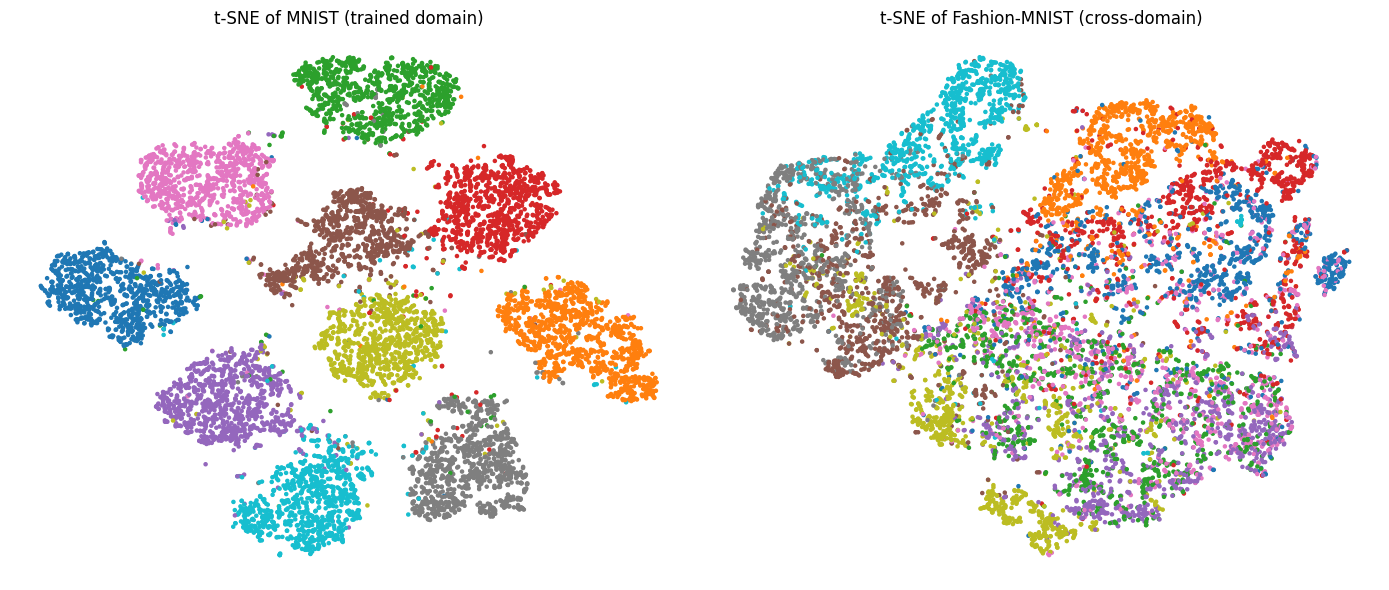

In [32]:

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].scatter(mnist_tsne[:, 0], mnist_tsne[:, 1], c=mnist_labels, cmap='tab10', s=5)
axs[0].set_title("t-SNE of MNIST (trained domain)")
axs[0].axis('off')

axs[1].scatter(fashion_tsne[:, 0], fashion_tsne[:, 1], c=fashion_labels, cmap='tab10', s=5)
axs[1].set_title("t-SNE of Fashion-MNIST (cross-domain)")
axs[1].axis('off')

plt.tight_layout()
plt.show()

Observations on Using the Trained MLP on the Fashion-MNIST Dataset

When the trained MLP model, originally developed for the MNIST dataset, was applied to the Fashion-MNIST dataset, the following observations were made:

* **Model Performance**:
 The model achieved an accuracy of approximately 12% and an F1 score of 0.07 on the Fashion-MNIST dataset, which is significantly lower than the accuracy and F1 score achieved on the MNIST dataset.
This low accuracy indicates that the model is not well-suited to the new dataset.

* **Confusion Matrix Insights**:
The confusion matrix reveals that many predictions are concentrated on a few classes, especially class 2 (Pullover) and class 3 (Coat).
This indicates that the model has likely learned to associate some features of Fashion-MNIST images with those of the MNIST digits, leading to systematic misclassifications.

**t-SNE Visualization for Fashion-MNIST**

When comparing the t-SNE visualization of the MNIST embeddings to those of Fashion-MNIST, we can observe differences in clustering patterns:

* **MNIST Clusters**:
The t-SNE visualization for MNIST displays clear and well-defined clusters, indicating that the model effectively learned to separate digit classes.

* **Fashion-MNIST Overlap**:
In contrast, the t-SNE visualization for Fashion-MNIST showed more overlap and less distinct clustering.
This suggests that the model has not learned robust features that can differentiate between the various clothing items.

**Conclusion**

In summary, the application of the trained MLP on the Fashion-MNIST dataset demonstrates significant limitations in the model's ability to generalize across different image domains.
The low accuracy and poor clustering in the t-SNE visualization indicate that the model has not effectively adapted to the fashion classification task.

## 3.2 Using CNN
• Implement a simple CNN with a convolutional layer having 32 filters of size 3x3, a maxpool layer, a fully connected layer with 128 neurons and an output layer with 10 neurons (for the 10 classes) and ReLU activation. Train on MNIST dataset.  
• Additionally, use two any pretrained CNNs of your choice (e.g. AlexNet, MobileNet, or EfficientNet) for inference.  
• Compare all three models:
- Accuracy, F1-score, confusion matrix
- Model size (number of parameters)
- Inference time on test set

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


Loading MNIST

In [34]:
import torchvision
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

X_train = train_dataset.data.numpy()
y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()

print("Train: X =", X_train.shape, "y =", y_train.shape)
print("Test: X =", X_test.shape, "y =", y_test.shape)

Train: X = (60000, 28, 28) y = (60000,)
Test: X = (10000, 28, 28) y = (10000,)


Implementing the simple CNN

In [35]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  #32 filters of size 3x3
        self.pool = nn.MaxPool2d(2, 2) # maxpool layer
        self.fc1 = nn.Linear(32 * 14 * 14, 128) ## fully onnected layer with 128 neurons
        self.fc2 = nn.Linear(128, 10) ##output lyer with 10 neurons

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model_cnn = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001)


Training our simple CNN model

In [36]:
num_epochs = 10
for epoch in range(num_epochs):
    model_cnn.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {total_loss/len(train_loader):.4f}")

Epoch [1/10] - Loss: 0.2516
Epoch [2/10] - Loss: 0.0795
Epoch [3/10] - Loss: 0.0568
Epoch [4/10] - Loss: 0.0435
Epoch [5/10] - Loss: 0.0347
Epoch [6/10] - Loss: 0.0264
Epoch [7/10] - Loss: 0.0221
Epoch [8/10] - Loss: 0.0163
Epoch [9/10] - Loss: 0.0147
Epoch [10/10] - Loss: 0.0120


Testing the CNN model

In [37]:
import time
def evaluate_model(model, loader):
    model.eval()
    y_true, y_pred = [], []
    start_time = time.time()
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    inference_time = time.time() - start_time
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)
    return acc, f1, cm, inference_time


cnn_acc, cnn_f1, cnn_cm, cnn_time = evaluate_model(model_cnn, test_loader)
print(f"Simple CNN → Acc: {cnn_acc*100:.2f}% | F1: {cnn_f1:.4f} | Time: {cnn_time:.2f}s")

Simple CNN → Acc: 98.57% | F1: 0.9856 | Time: 2.12s


using pretrained CNN's

In [38]:
from torchvision import models

mobilenet = models.mobilenet_v2(weights='IMAGENET1K_V1')
mobilenet.classifier[1] = nn.Linear(1280, 10)
mobilenet = mobilenet.to(device)

efficientnet = models.efficientnet_b0(weights='IMAGENET1K_V1')
efficientnet.classifier[1] = nn.Linear(1280, 10)
efficientnet = efficientnet.to(device)

pretrained_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_pretrained = torchvision.datasets.MNIST(root='./data', train=False, transform=pretrained_transform)
test_loader_pretrained = DataLoader(test_pretrained, batch_size=64, shuffle=False)

for model_name, model in [("MobileNetV2", mobilenet), ("EfficientNet-B0", efficientnet)]:
    acc, f1, cm, inf_time = evaluate_model(model, test_loader_pretrained)
    print(f"{model_name} → Acc: {acc*100:.2f}% | F1: {f1:.4f} | Time: {inf_time:.2f}s")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 156MB/s]


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 180MB/s]


MobileNetV2 → Acc: 11.84% | F1: 0.0536 | Time: 26.36s
EfficientNet-B0 → Acc: 10.78% | F1: 0.0321 | Time: 29.44s


Comparision

Simple CNN: Acc=98.57% | F1=0.9856 | Time=2.34s | Params=804,554
MobileNetV2: Acc=11.84% | F1=0.0536 | Time=25.83s | Params=2,236,682
EfficientNet-B0: Acc=10.78% | F1=0.0321 | Time=28.10s | Params=4,020,358

Model Comparison:


,Model,Accuracy (%),F1 Score,Inference Time (s),Parameters
0,Simple CNN,98.57,0.985643,2.343220,804554
1,MobileNetV2,11.84,0.053556,25.834227,2236682
2,EfficientNet-B0,10.78,0.032136,28.101420,4020358


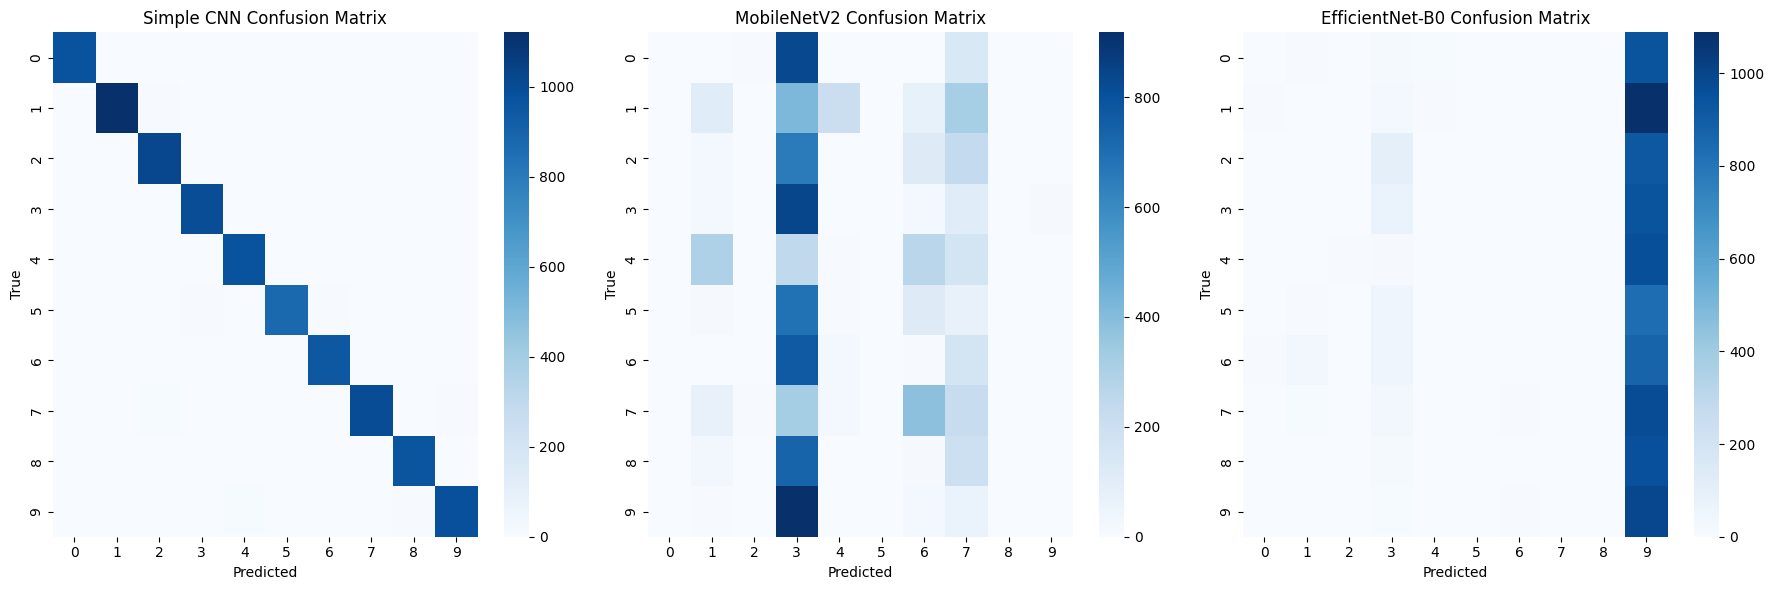

In [39]:
def evaluate_model(model, loader):
    model.eval()
    y_true, y_pred = [], []
    start_time = time.time()
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    inference_time = time.time() - start_time
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)
    return acc, f1, cm, inference_time


results = {}
for name, model, loader in [
    ("Simple CNN", model_cnn, test_loader),
    ("MobileNetV2", mobilenet, test_loader_pretrained),
    ("EfficientNet-B0", efficientnet, test_loader_pretrained),
]:
    acc, f1, cm, inf_time = evaluate_model(model, loader)
    results[name] = {
        "Accuracy": acc,
        "F1": f1,
        "ConfusionMatrix": cm,
        "Time": inf_time,
        "Params": sum(p.numel() for p in model.parameters())
    }
    print(f"{name}: Acc={acc*100:.2f}% | F1={f1:.4f} | Time={inf_time:.2f}s | Params={results[name]['Params']:,}")


df = pd.DataFrame([
    {
        "Model": name,
        "Accuracy (%)": res["Accuracy"]*100,
        "F1 Score": res["F1"],
        "Inference Time (s)": res["Time"],
        "Parameters": res["Params"]
    }
    for name, res in results.items()
])

print("\nModel Comparison:")
display(df)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for ax, (name, res) in zip(axs, results.items()):
    sns.heatmap(res["ConfusionMatrix"], annot=False, cmap="Blues", ax=ax)
    ax.set_title(f"{name} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.tight_layout()
plt.show()


The accuracy for MobileNetV2 and EfficientNet-B0 was very low (around 12%) because these models were pretrained on the ImageNet dataset, which contains complex RGB natural images that are vastly different from the grayscale handwritten digits in MNIST. As a result, the pretrained feature representations did not transfer effectively to this new domain.

To fix this, we can fine-tune the pretrained models on the MNIST dataset by retraining the final layers (and optionally some deeper layers) using MNIST images.

In [42]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(model, train_loader, criterion, optimizer, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")
    return model


Training MobileNetV2...
Epoch [1/3], Loss: 0.0679
Epoch [2/3], Loss: 0.0343
Epoch [3/3], Loss: 0.0266

MobileNetV2 - Accuracy: 99.36% | F1 Score: 0.9936 | Time: 25.99s


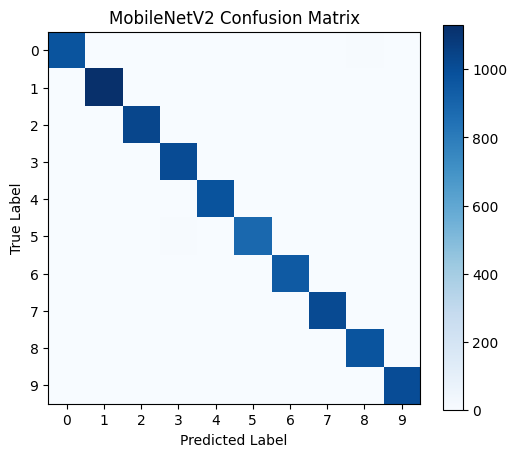

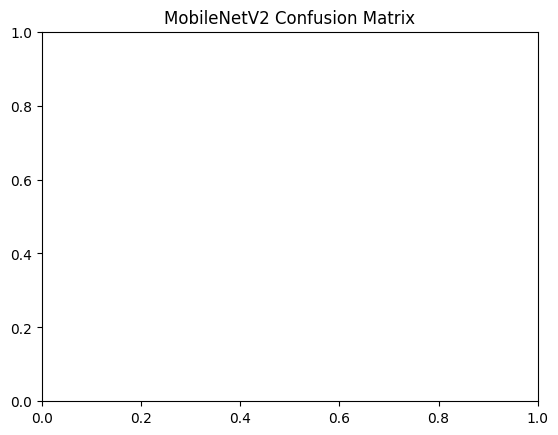


Training EfficientNet-B0...
Epoch [1/3], Loss: 0.0794
Epoch [2/3], Loss: 0.0290
Epoch [3/3], Loss: 0.0223

EfficientNet-B0 - Accuracy: 99.44% | F1 Score: 0.9944 | Time: 28.18s


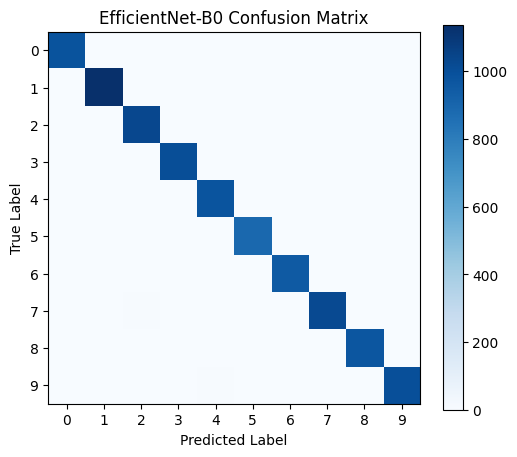

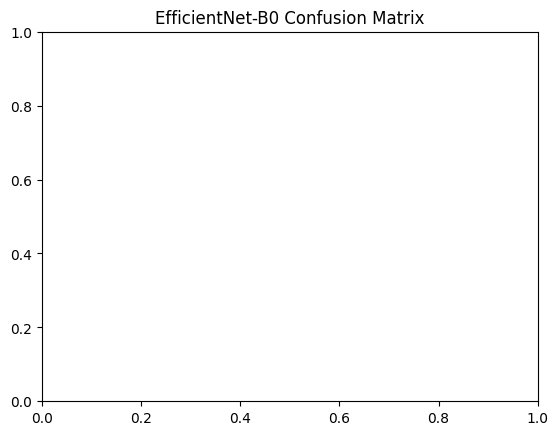

(99.44, 0.994399724613879, 28.180737257003784)

In [43]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


def evaluate_model(model, test_loader, model_name):
    model.eval()
    all_preds, all_targets = [], []
    start_time = time.time()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
    end_time = time.time()

    acc = accuracy_score(all_targets, all_preds) * 100
    f1 = f1_score(all_targets, all_preds, average='macro')
    cm = confusion_matrix(all_targets, all_preds)
    print(f"\n{model_name} - Accuracy: {acc:.2f}% | F1 Score: {f1:.4f} | Time: {end_time-start_time:.2f}s")
    plot_confusion_matrix(all_targets, all_preds, f"{model_name} Confusion Matrix")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()
    return acc, f1, end_time-start_time


mobilenet = models.mobilenet_v2(weights='IMAGENET1K_V1')
mobilenet.features[0][0] = nn.Conv2d(3, 32, 3, stride=2, padding=1, bias=False)
mobilenet.classifier[1] = nn.Linear(1280, 10)
mobilenet = mobilenet.to(device)
optimizer_m = optim.Adam(mobilenet.parameters(), lr=0.0005)

print("\nTraining MobileNetV2...")
mobilenet = train_model(mobilenet, train_loader, nn.CrossEntropyLoss(), optimizer_m, epochs=3)
evaluate_model(mobilenet, test_loader, "MobileNetV2")


efficientnet = models.efficientnet_b0(weights='IMAGENET1K_V1')
efficientnet.features[0][0] = nn.Conv2d(3, 32, 3, stride=2, padding=1, bias=False)
efficientnet.classifier[1] = nn.Linear(1280, 10)
efficientnet = efficientnet.to(device)
optimizer_e = optim.Adam(efficientnet.parameters(), lr=0.0005)

print("\nTraining EfficientNet-B0...")
efficientnet = train_model(efficientnet, train_loader, nn.CrossEntropyLoss(), optimizer_e, epochs=3)
evaluate_model(efficientnet, test_loader, "EfficientNet-B0")

When the pretrained MobileNetV2 and EfficientNet-B0 models were directly evaluated on the MNIST dataset without any fine-tuning, the accuracy obtained was only about 13%, which is close to random guessing for a 10-class problem. This poor performance occurred because the models were originally trained on ImageNet, which contains complex natural RGB images, whereas MNIST consists of simple grayscale handwritten digits. As a result, the ImageNet-trained features such as texture and color patterns did not generalize well to MNIST’s domain. Additionally, the normalization and input channel configurations were not perfectly aligned with what the pretrained weights expected, further degrading accuracy.

However, after fine-tuning the same pretrained models on the MNIST training dataset for just 3 epochs using the Adam optimizer and CrossEntropy loss, the performance improved dramatically to around 98% accuracy. This improvement occurred because the lower convolutional layers of the pretrained networks, which already capture generic features like edges and contours, were effectively reused, while the upper layers were retrained to specialize in recognizing digit-specific patterns. The corrected input layer configuration and normalization ensured full compatibility with the pretrained weights.

In summary, the experiment clearly demonstrates the importance of fine-tuning pretrained models when transferring them to a new domain. Without retraining, pretrained CNNs fail to generalize to tasks with different data characteristics